In [1]:
import pandas as pd
import seaborn as sns
import sys
sys.path.append('../')
from conversion_from_clinical import utils

In [2]:
ADNIMERGE = '../data/adni/ADNIMERGE.csv'
MOCA = '../data/adni/MOCA.csv'
MMSE = '../data/adni/MMSE.csv'

In [3]:
df = pd.read_csv(ADNIMERGE)
df['Visit_Month'] = df['VISCODE'].apply(lambda x: utils.dictVisit2Months[x])
df = df.loc[df['DX_bl'] == 'AD']
df.index = pd.MultiIndex.from_frame(df[['PTID', 'Visit_Month']])
df.head()

RID        PTID VISCODE  SITE COLPROT ORIGPROT  \
PTID       Visit_Month                                                   
011_S_0003 0              3  011_S_0003      bl    11   ADNI1    ADNI1   
           6              3  011_S_0003     m06    11   ADNI1    ADNI1   
           12             3  011_S_0003     m12    11   ADNI1    ADNI1   
           24             3  011_S_0003     m24    11   ADNI1    ADNI1   
022_S_0007 0              7  022_S_0007      bl    22   ADNI1    ADNI1   

                          EXAMDATE DX_bl   AGE PTGENDER  ...  PTAU_bl  \
PTID       Visit_Month                                   ...            
011_S_0003 0            2005-09-12    AD  81.3     Male  ...    22.83   
           6            2006-03-13    AD  81.3     Male  ...    22.83   
           12           2006-09-12    AD  81.3     Male  ...    22.83   
           24           2007-09-12    AD  81.3     Male  ...    22.83   
022_S_0007 0            2005-10-06    AD  75.4     Male  ...      NaN   

                         FDG_bl PIB_bl AV45_bl  Years_bl  Month_bl  Month  \
PTID       Visit_Month                                                      
011_S_0003 0            1.08355    NaN     NaN  0.000000   0.00000      0   
           6            1.08355    NaN     NaN  0.498289   5.96721      6   
           12           1.08355    NaN     NaN  0.999316  11.96720     12   
           24           1.08355    NaN     NaN  1.998630  23.93440     24   
022_S_0007 0                NaN    NaN     NaN  0.000000   0.00000      0   

                           M           update_stamp Visit_Month  
PTID       Visit_Month                                           
011_S_0003 0             0.0  2020-01-09 04:20:17.0           0  
           6             6.0  2020-03-25 15:43:58.0           6  
           12           12.0  2020-01-09 04:20:17.0          12  
           24           24.0  2020-01-09 04:20:17.0          24  
022_S_0007 0             0.0  2020-01-09 04:20:18.0           0  

[5 rows x 114 columns]

472 observations available with 12 month change
292 unique subjects


<AxesSubplot:ylabel='Count'>

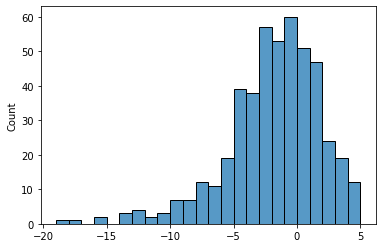

In [4]:
# compute MMSE change 24 months after each observation
delta = 12
dfDeltaMMSE = pd.Series(index=df.index)
for idx, row in df.iterrows():
    strSub, month = idx
    if (strSub, month + delta) in df.index:
        dfDeltaMMSE.loc[(strSub, month)] = df['MMSE'].loc[(strSub, month + delta)] - df['MMSE'].loc[(strSub, month)]
dfDeltaMMSE = dfDeltaMMSE.dropna()
print(dfDeltaMMSE.shape[0], 'observations available with', delta, 'month change')  
print(dfDeltaMMSE.index.get_level_values(0).unique().shape[0], 'unique subjects')    
sns.histplot(data=dfDeltaMMSE)


In [16]:
dfMMSEFromTable = pd.Series(index=df.index)
dfMMSE = pd.read_csv(MMSE)
dfMMSE = dfMMSE.loc[~dfMMSE['VISCODE2'].isna()]
dfMMSE = dfMMSE.loc[dfMMSE['VISCODE2'] != 'f'] # no idea what visit f mean
dfMMSE['Visit_Month'] = dfMMSE['VISCODE2'].apply(lambda x: utils.dictVisit2Months[x])
dfMMSE.index = pd.MultiIndex.from_frame(dfMMSE[['RID', 'Visit_Month']])
for idx, row in df.iterrows():
    if (row['RID'], row['Visit_Month']) in dfMMSE.index:
        dfMMSEFromTable.loc[idx] = dfMMSE['MMSCORE'].loc[(row['RID'], row['Visit_Month'])].values
dfMMSEFromTable

PTID        Visit_Month
011_S_0003  0              20.0
            6              24.0
            12             17.0
            24             19.0
022_S_0007  0              20.0
                           ... 
022_S_6863  0              26.0
168_S_6754  12             26.0
022_S_6796  12             23.0
037_S_6377  24             17.0
123_S_6825  12             18.0
Length: 1666, dtype: float64

478 observations available with 12 month change
293 unique subjects
ADNI1    306
ADNI2    134
ADNI3     38
Name: Study, dtype: int64


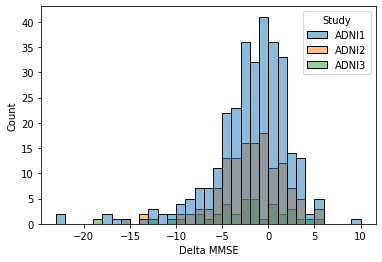

In [25]:
delta = 12
dfDeltaMMSE2 = pd.DataFrame(columns=['Delta MMSE', 'Study'], index=dfMMSEFromTable.index)
for idx in dfMMSEFromTable.index:
    strSub, month = idx
    if (strSub, month + delta) in dfMMSEFromTable.index:
        dfDeltaMMSE2['Delta MMSE'].loc[idx] = dfMMSEFromTable.loc[(strSub, month + delta)] - dfMMSEFromTable.loc[(strSub, month)]
        dfDeltaMMSE2['Study'].loc[idx] = df['COLPROT'].loc[idx]
dfDeltaMMSE2 = dfDeltaMMSE2.dropna()
print(dfDeltaMMSE2.shape[0], 'observations available with', delta, 'month change')  
print(dfDeltaMMSE2.index.get_level_values(0).unique().shape[0], 'unique subjects')    
sns.histplot(data=dfDeltaMMSE2, x='Delta MMSE', hue='Study') # break down by study?
print(dfDeltaMMSE2['Study'].value_counts())

In [22]:
dfDeltaMMSE2

Delta MMSE  Study
PTID       Visit_Month                  
011_S_0003 0                   -3  ADNI1
           12                   2  ADNI1
022_S_0007 0                    0  ADNI1
011_S_0010 0                    1  ADNI1
           12                   3  ADNI1
...                           ...    ...
135_S_6389 12                  -5  ADNI3
168_S_6754 0                    2  ADNI3
129_S_6763 0                   -6  ADNI3
022_S_6796 0                    3  ADNI3
123_S_6825 0                   -6  ADNI3

[478 rows x 2 columns]

In [6]:
dfMMSE['VISCODE2'].value_counts()

sc      3254
m12     1665
m06     1617
m24     1464
m36      829
m48      693
m72      456
m60      431
f        407
m84      336
m18      329
m96      247
m108     129
m120      79
m132      55
m144      44
m156      39
m168      10
m180       1
Name: VISCODE2, dtype: int64